# Fine-tuning Whisper on Speech Pathology Dataset

## Goal

The goal of the Cleft Palate project (name TBD) at Vanderbilt DSI is to classify audio clips of patients' voices as containing hypernasality (a speech impediment) or not. The patients with hypernasality can then be recommended for speech pathology intervention. This is currently evaluated by human speech pathologists, which requires access to these medical providers. Our hope is to train a model that can classify this speech impediment for expedited patient access to a speech pathologist.

## Model

In this notebook we train the Whisper model with a Sequence Classification Head.

## Data

The data in this notebook is publicly available voice recordings featuring hypernasality and control groups. In the future we hope to train our model on private patient data from Vanderbilt University Medical Center (VUMC).

In [5]:
# FOR GOOGLE DRIVE USE ONLY
!pip install torch
!pip install datasets
!pip install librosa
!pip install transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [6]:
# import libraries
import datasets
from datasets import load_dataset, DatasetDict,  Audio
import pandas as pd
import os
import glob
import librosa
import io
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, accuracy_score
from transformers import WhisperModel, WhisperFeatureExtractor, AdamW
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset, load_from_disk

In [7]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Load PyTorch datasets

If you have not already, run the `01-load-data.ipynb` notebook to create the files "../data/train_dataset.pt", "../data/val_dataset.pt", and "../data/test_dataset.pt". Then, load them using the cell below.

In [8]:
# load data from disk
train_audio_dataset = load_from_disk('/content/drive/MyDrive/cleft_palate/content/cleft_palate/data/public_samples/extracted_files/train_dataset')
test_audio_dataset = load_from_disk('/content/drive/MyDrive/cleft_palate/content/cleft_palate/data/public_samples/extracted_files/test_dataset')
val_audio_dataset = load_from_disk('/content/drive/MyDrive/cleft_palate/content/cleft_palate/data/public_samples/extracted_files/val_dataset')

In [9]:
model_checkpoint = "openai/whisper-base"

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_checkpoint)
encoder = WhisperModel.from_pretrained(model_checkpoint)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

In [10]:

class SpeechClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, audio_data,  text_processor):
        self.audio_data = audio_data
        self.text_processor = text_processor

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, index):

      inputs = self.text_processor(self.audio_data[index]["audio"]["array"],
                                   return_tensors="pt",
                                   sampling_rate=self.audio_data[index]["audio"]["sampling_rate"])
      input_features = inputs.input_features
      decoder_input_ids = torch.tensor([[1, 1]]) * encoder.config.decoder_start_token_id

      labels = np.array(self.audio_data[index]['labels'])

      return input_features, decoder_input_ids, torch.tensor(labels)


In [11]:
train_dataset = SpeechClassificationDataset(train_audio_dataset,  feature_extractor)
test_dataset = SpeechClassificationDataset(test_audio_dataset,  feature_extractor)
val_dataset = SpeechClassificationDataset(val_audio_dataset,  feature_extractor)

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Training

Training for Whisper model.

In [12]:

class SpeechClassifier(nn.Module):
    def __init__(self, num_labels, encoder):
        super(SpeechClassifier, self).__init__()
        self.encoder = encoder


        self.classifier = nn.Sequential(
            nn.Linear(self.encoder.config.hidden_size, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_labels)
        )


        # Method of reducing model complexity
        '''
        self.classifier = nn.Sequential(
        nn.Linear(self.encoder.config.hidden_size, 2048),
        nn.ReLU(),
        nn.Linear(2048, 1024),
        nn.ReLU(),
        nn.Linear(1024, num_labels)
        )
        '''




        # Method of Batch normalization
        '''
        self.classifier = nn.Sequential(
            nn.Linear(self.encoder.config.hidden_size, 4096),
            nn.ReLU(),
            nn.BatchNorm1d(4096),
            nn.Dropout(0.5),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, num_labels)
        )
        '''




    def forward(self, input_features, decoder_input_ids):
        outputs = self.encoder(input_features, decoder_input_ids=decoder_input_ids)
        pooled_output = outputs['last_hidden_state'][:, 0, :]
        logits = self.classifier(pooled_output)
        return logits



In [13]:
num_labels = 2

model = SpeechClassifier(num_labels, encoder).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, betas=(0.9, 0.999), eps=1e-08)
# optimizer = AdamW(model.parameters(), lr=2e-5, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4) # Using L2 regularization
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
#@title Method of earlystopping
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):
        self.tolerance = tolerance
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.min_delta = min_delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.tolerance:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'whisper_best_model.pt')
        self.val_loss_min = val_loss

def train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs):
    early_stopping = EarlyStopping(tolerance=5)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, batch in enumerate(train_loader):
            input_features, decoder_input_ids, labels = batch
            input_features = input_features.squeeze().to(device)
            decoder_input_ids = decoder_input_ids.squeeze().to(device)
            labels = labels.view(-1).type(torch.LongTensor).to(device)

            optimizer.zero_grad()
            logits = model(input_features, decoder_input_ids)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if (i+1) % 8 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, Train Loss: {loss.item():.4f}')

        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        val_loss, val_accuracy, val_f1, _, _ = evaluate(model, val_loader, device)
        val_losses.append(val_loss)

        print("========================================================================================")
        print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}')
        print("========================================================================================")

        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    return train_losses, val_losses

In [ ]:
#@title Method of learning rate scheduler
from transformers import get_linear_schedule_with_warmup

total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(total_steps*0.1), num_training_steps=total_steps)

def train(model, train_loader, val_loader, optimizer,  criterion, device, num_epochs):

    best_accuracy = 0.0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, batch in enumerate(train_loader):
            input_features, decoder_input_ids, labels = batch
            input_features = input_features.squeeze().to(device)
            decoder_input_ids = decoder_input_ids.squeeze().to(device)
            labels = labels.view(-1).type(torch.LongTensor).to(device)
            optimizer.zero_grad()
            logits = model(input_features, decoder_input_ids)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()  # Update learning rate
            running_loss += loss.item()

            if (i+1) % 8 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, Train Loss: {loss.item() :.4f}')

        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        val_loss, val_accuracy, val_f1, _ , _ = evaluate(model, val_loader, device)
        val_losses.append(val_loss)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'whisper_best_model.pt')
        print("========================================================================================")
        print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}, Best Accuracy: {best_accuracy:.4f}')
        print("========================================================================================")

    return train_losses, val_losses


In [ ]:
import torchaudio.transforms as T
import torch.nn as nn

def augment_audio(waveform, sample_rate):
    augmentations = nn.Sequential(
        T.FrequencyMasking(freq_mask_param=15),
        T.TimeMasking(time_mask_param=35)
    )
    return augmentations(waveform)

# Define the training function
def train(model, train_loader, val_loader, optimizer,  criterion, device, num_epochs):

    best_accuracy = 0.0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):

        model.train()
        running_loss = 0.0

        for i, batch in enumerate(train_loader):

            input_features, decoder_input_ids, labels = batch

            input_features = input_features.squeeze()
            # Method of data augmentation
            # augmented_features = augment_audio(input_features, sample_rate=16000)
            input_features = input_features.to(device)

            decoder_input_ids = decoder_input_ids.squeeze()
            decoder_input_ids = decoder_input_ids.to(device)

            labels = labels.view(-1)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)

            optimizer.zero_grad()

            logits = model(input_features, decoder_input_ids)

            loss = criterion(logits, labels)
            loss.backward()

            optimizer.step()
            running_loss += loss.item()

            if (i+1) % 8 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, Train Loss: {loss.item() :.4f}')
                train_loss = 0.0

        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        val_loss, val_accuracy, val_f1, _ , _ = evaluate(model, val_loader, device)
        val_losses.append(val_loss)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'whisper_best_model.pt')

        print("========================================================================================")
        print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}, Best Accuracy: {best_accuracy:.4f}')
        print("========================================================================================")
    return train_losses, val_losses

In [18]:
def evaluate(model, data_loader, device):
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            input_features, decoder_input_ids, labels = batch
            input_features = input_features.squeeze().to(device)
            decoder_input_ids = decoder_input_ids.squeeze().to(device)
            labels = labels.view(-1).type(torch.LongTensor).to(device)

            logits = model(input_features, decoder_input_ids)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            _, preds = torch.max(logits, 1)
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)
    loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return loss, accuracy, f1, all_labels, all_preds



In [19]:
import librosa
num_epochs = 10
train_losses, val_losses = train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs)

Epoch 1/10, Batch 8/13, Train Loss: 0.8110
Epoch 1/10, Val Loss: 0.5944, Val Accuracy: 0.7778, Val F1: 0.7685
Epoch 2/10, Batch 8/13, Train Loss: 0.2296
Epoch 2/10, Val Loss: 0.3635, Val Accuracy: 0.8889, Val F1: 0.8887
Epoch 3/10, Batch 8/13, Train Loss: 0.3717
Epoch 3/10, Val Loss: 1.5940, Val Accuracy: 0.6222, Val F1: 0.5503
Epoch 4/10, Batch 8/13, Train Loss: 0.0076
Epoch 4/10, Val Loss: 0.6968, Val Accuracy: 0.7778, Val F1: 0.7685
Epoch 5/10, Batch 8/13, Train Loss: 0.0065
Epoch 5/10, Val Loss: 0.7454, Val Accuracy: 0.8000, Val F1: 0.7984
Epoch 6/10, Batch 8/13, Train Loss: 0.0020
Epoch 6/10, Val Loss: 0.8588, Val Accuracy: 0.8000, Val F1: 0.7984
Epoch 7/10, Batch 8/13, Train Loss: 0.0004
Epoch 7/10, Val Loss: 0.9162, Val Accuracy: 0.8222, Val F1: 0.8214
Early stopping


### Evaluation

#### Validation Set

Evaluate how our model performs on the validation set.

In [20]:
#VALIDATION
state_dict = torch.load('whisper_best_model.pt')

# Create a new instance of the model and load the state dictionary
num_labels = 2
model = SpeechClassifier(num_labels, encoder).to(device)
model.load_state_dict(state_dict)

_, _, _, all_labels, all_preds = evaluate(model, val_loader, device)

In [21]:
#VALIDATION
print(classification_report(all_labels, all_preds))
print(accuracy_score(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89        22
           1       0.95      0.83      0.88        23

    accuracy                           0.89        45
   macro avg       0.90      0.89      0.89        45
weighted avg       0.90      0.89      0.89        45

0.8888888888888888


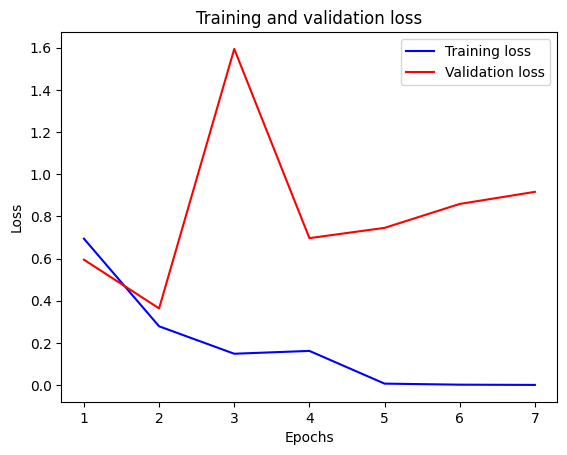

In [22]:
import matplotlib.pyplot as plt

# Plot of earlyStopping
epochs = range(1, len(train_losses) + 1)

# Plot of other methods
# epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()